In [43]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# ML library
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc
import pickle


### Loading Data and Data Summary

In [44]:
algorithms = {
    'SVC-RBF': SVC(kernel='linear', class_weight='balanced', C=1.0, probability=True),
    'RandomForest': RandomForestClassifier(random_state=42),
    # 'Neural-Network-5': MLPClassifier(hidden_layer_sizes=[5], max_iter=20000, random_state=42),
    # 'DecisionTree': DecisionTreeClassifier(random_state=42),
    # 'GradientBoosting': GradientBoostingClassifier(random_state=42),
    # 'KNeighbors': KNeighborsClassifier(n_neighbors=5),
}
file_path = '../outputs/features_data_grp_1_master.csv'
# file_path = 'features_data_testing_1.csv'
np.random.seed(42)

##Program Starting Here!

In [45]:
def apply_sampling(X, y):
  # summarize class distribution
  print("Original :",Counter(y))
  rus = RandomUnderSampler(sampling_strategy={0: len(y[y != 0])}, random_state=42)
  X_rus, y_rus = rus.fit_resample(X, y)
  print("\nAfter Random Undersampling on class 0:", Counter(y_rus))
  return X_rus, y_rus

In [46]:
# Train and test model
def trainAndTestSplitData(X_features, y_features):
  # split into train/test sets with same class ratio
  trainX, testX, trainy, testy = model_selection.train_test_split(X_features, y_features, test_size=0.2,random_state=42, stratify=y_features)
  return trainX, testX, trainy, testy

In [47]:
def execute_model(trainX, testX, trainy, testy, model, create_pickle=True):
  # fit model
  model.fit(trainX, trainy)
  #save model to pickle file
  if create_pickle:
      with open(f'../models/{model.__class__.__name__}_model.pkl', 'wb') as f:
          pickle.dump(model, f)
  
  # predict on test set
  yhat = model.predict(testX)
  # evaluate predictions
  acc = metrics.accuracy_score(testy, yhat)
  prec = metrics.precision_score(testy, yhat, average='weighted')
  recall = metrics.recall_score(testy, yhat, average='weighted')
  f1_score = metrics.f1_score(testy, yhat, average='weighted')
  # Get classification report as dict for class-wise metrics
  classification_report = metrics.classification_report(testy, yhat, output_dict=True)
  return acc, prec, recall, f1_score, classification_report


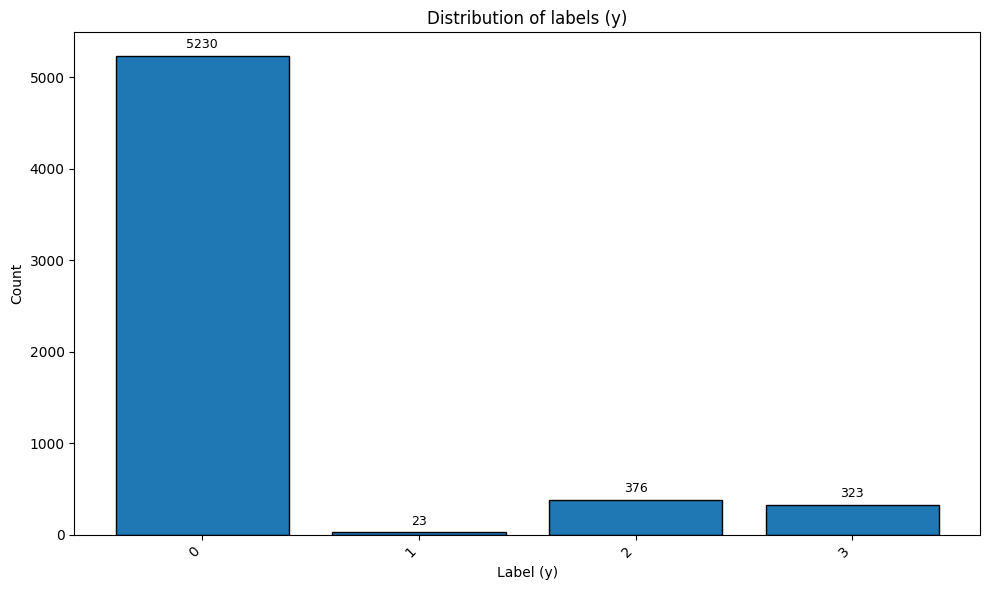

Number of features: 3194


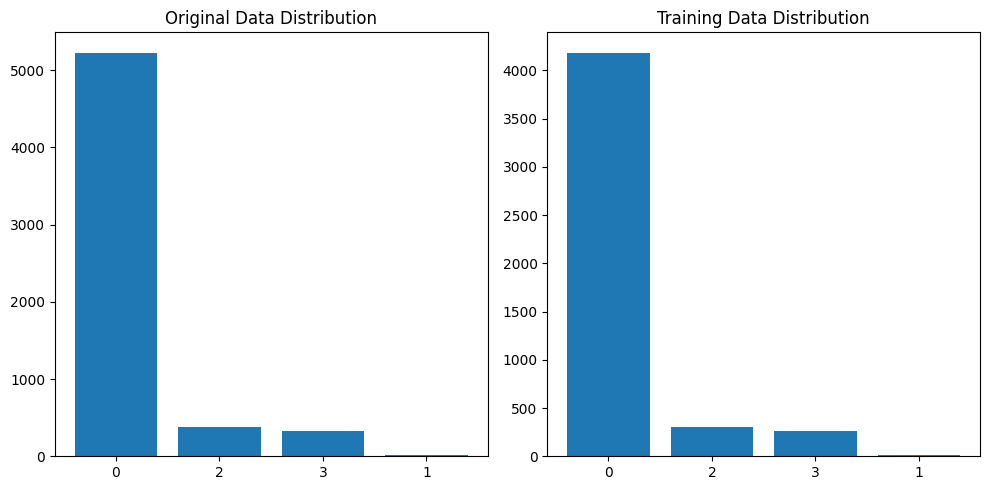

i:\Test\pml-project\final-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
i:\Test\pml-project\final-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
i:\Test\pml-project\final-env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
i:\Test\pml-p

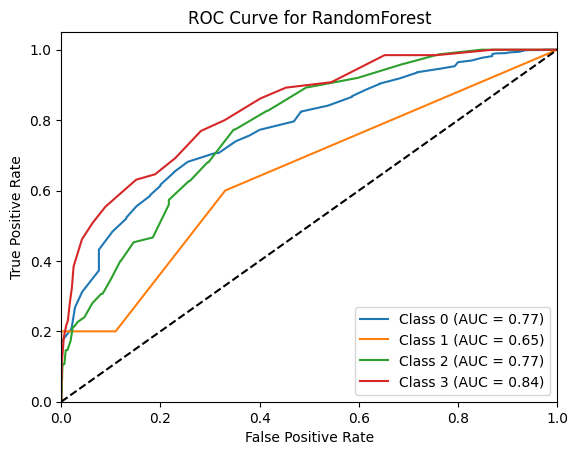

In [48]:
import os

from sklearn.preprocessing import StandardScaler

apply_manual_undersampling = False
df = pd.read_csv(file_path)
df_clean = df.dropna()
X = df_clean.drop(['image','tile_number', 'tile_i', 'tile_j', 'y'], axis=1)
y = df_clean['y']

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

counts = df_clean['y'].value_counts().sort_index()   # or .sort_values(ascending=False)
plt.figure(figsize=(10,6))
bars = plt.bar(counts.index.astype(str), counts.values, color='tab:blue', edgecolor='k')
plt.xlabel('Label (y)')
plt.ylabel('Count')
plt.title('Distribution of labels (y)')
plt.xticks(rotation=45, ha='right')

# annotate counts on top of each bar
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + max(counts.values)*0.01, f'{int(h)}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

if apply_manual_undersampling:
    ### Step 1: Apply Random Undersampling on class 0
    X_us, y_us = apply_sampling(X, y)
    ### Step 2: Train and Test Split on undersampled data
    trainX, testX, trainy, testy = trainAndTestSplitData(X_us, y_us)
else:
    ### Step 2: Train and Test Split on original data
    trainX, testX, trainy, testy = trainAndTestSplitData(X, y)

# Apply StandardScaler
scaler = StandardScaler()
trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)

print(f'Number of features: {trainX_scaled.shape[1]}')

### Plotting - Class distribution
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(y.value_counts().index.astype(str), y.value_counts().values)
ax[0].set_title("Original Data Distribution")
ax[1].bar(trainy.value_counts().index.astype(str), trainy.value_counts().values)
ax[1].set_title("Training Data Distribution")
plt.tight_layout()
plt.show()
 
all_model_reports_list = []
for model_name, model in algorithms.items():
   
    acc, prec, recall, f1, report = execute_model(trainX_scaled, testX_scaled, trainy, testy, model, create_pickle=True)
    df_result = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [recall],
        'F1_score': [f1]
    })

    df_result.index = ['Scaled Data']

all_model_reports_list.append({
    'Model': model_name,
    'Scaled Data': report
})

y_proba = model.predict_proba(testX_scaled)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(testy))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testy == i, y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc='lower right')
plt.show()


In [49]:

# Now, let's process the collected reports and display them in a table.
records = []
for report_item in all_model_reports_list:
    model_name = report_item['Model']
    for technique, report in report_item.items():
        if technique == 'Model':
            continue
        
        # Extract overall metrics
        records.append({
            'Model': model_name,
            'Technique': technique,
            'Class': 'accuracy',
            'F1-Score': report.get('accuracy', None),
            'Precision': None,
            'Recall': None,
            'Support': report.get('macro avg', {}).get('support', None)
        })
        
        # Extract class-specific and average metrics
        for class_label, metrics in report.items():
            if isinstance(metrics, dict): # This will capture classes and averages like 'macro avg'
                records.append({
                    'Model': model_name,
                    'Technique': technique,
                    'Class': class_label,
                    'F1-Score': metrics.get('f1-score'),
                    'Precision': metrics.get('precision'),
                    'Recall': metrics.get('recall'),
                    'Support': metrics.get('support')
                })

# Create a DataFrame and display it
df_reports = pd.DataFrame(records)

# Pivot for a more readable, wide-format table
report_table = df_reports.pivot_table(
    index=['Model', 'Technique'], 
    columns='Class', 
    values='F1-Score'
)

# Reorder columns for better readability
desired_order = [c for c in sorted(df_reports['Class'].unique(), key=lambda x: (str.isdigit(x), x)) if c in report_table.columns]
report_table = report_table[desired_order]


print("--- All Model Reports (F1-Scores) ---")
# Display the styled DataFrame
report_table.style.background_gradient(cmap='viridis', axis=1).format("{:.4f}").set_caption("F1-Scores by Model, Technique, and Class")

--- All Model Reports (F1-Scores) ---


,Class,accuracy,macro avg,weighted avg,0,1,2,3
Model,Technique,,,,,,,
RandomForest,Scaled Data,0.8808,0.3304,0.8271,0.9364,0.3333,0.0519,0.0000


In [50]:
# file_path = 'features_data_testing_1.csv'
# np.random.seed(42)

# df = pd.read_csv(file_path)
# df_clean = df.dropna()
# X = df_clean.drop(['image', 'tile_i', 'tile_j'], axis=1)
# print(X.shape)

# #Apply MinMaxScaler
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # #Perform PCA
# # pca = PCA(n_components=484)  # retain 95% of variance
# # X_pca = pca.fit_transform(X_scaled)

# #Load pca from pickle file
# with open('../models/pca_model.pkl', 'rb') as f:
#     pca = pickle.load(f)

# X_pca = pca.transform(X_scaled)

# #load pickle file from ../models/RandomForest_model.pkl and use it for prediction
# with open('../models/RandomForestClassifier_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# prediction = loaded_model.predict(X_pca)
# print(prediction)